In [1]:
import pandas as pd
import numpy as np
import math
import datetime as dt

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler


In [3]:
df1= pd.read_csv("/content/BTC_DATA_1h_2024.csv")
df1.tail()

,timestamp,open,high,low,close,volume,quote_asset_volume,RSI14,RSI30,RSI200,...,EMA12,EMA26,MACD,PROC9,Low14,High14,%K,%K10,%K30,%K200
35995,2024-02-10 03:00:00,47311.40,47504.00,47311.39,47376.62,1148.05953,5.442332e+07,64.338371,66.940151,57.812241,...,47256.180028,46871.998340,384.181688,-0.473468,46652.00,48200.0,46.810078,51.327428,72.755821,59.617938
35996,2024-02-10 04:00:00,47376.62,47430.03,47313.29,47409.50,534.44554,2.531818e+07,64.954142,67.190281,57.866709,...,47279.767716,46911.813278,367.954438,-0.210442,46765.44,48200.0,44.895996,48.454363,72.048810,59.444377
35997,2024-02-10 05:00:00,47409.49,47421.29,47255.39,47326.83,489.20761,2.317098e+07,62.052919,65.893557,57.678532,...,47287.008067,46942.555257,344.452810,-0.388245,47035.92,48200.0,24.990550,44.292764,70.625060,59.139735
35998,2024-02-10 06:00:00,47326.82,47350.00,47265.69,47349.99,473.08547,2.238342e+07,62.557481,66.083258,57.717246,...,47296.697595,46972.735608,323.961987,-0.331023,47035.92,48200.0,26.980104,40.417193,69.266140,58.908201
35999,2024-02-10 07:00:00,47349.99,47352.98,47145.40,47151.72,658.55420,3.112403e+07,55.726246,62.980959,57.266529,...,47274.393350,46985.993711,288.399638,-0.255729,47035.92,48200.0,9.947770,34.878371,66.668710,58.533370


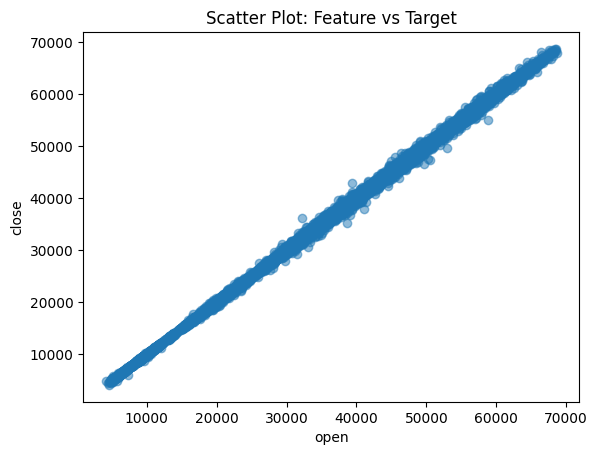

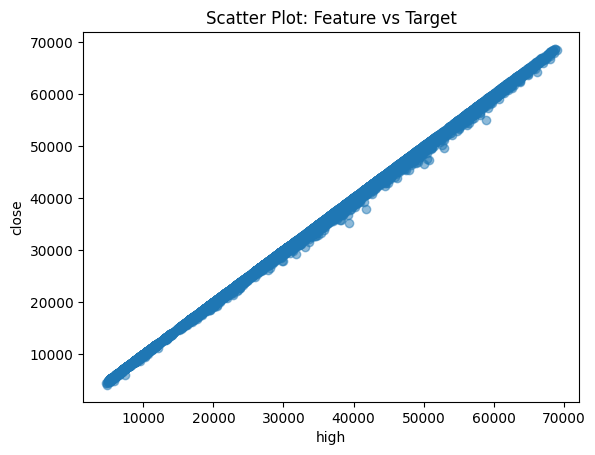

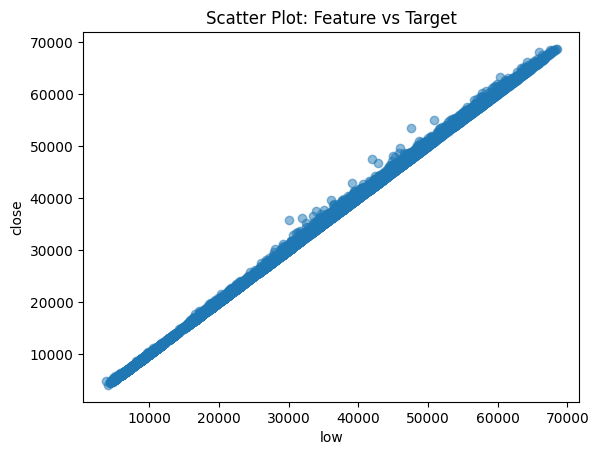

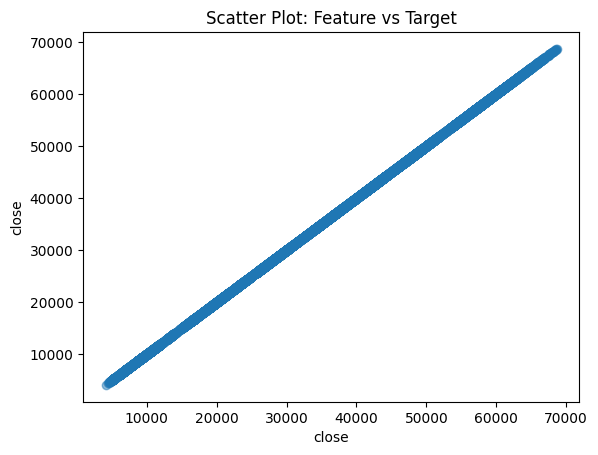

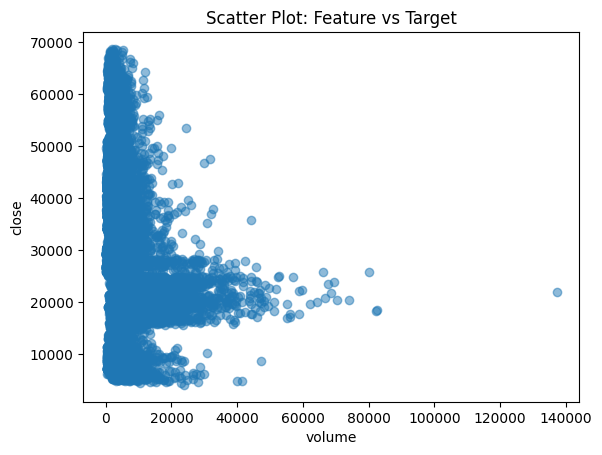

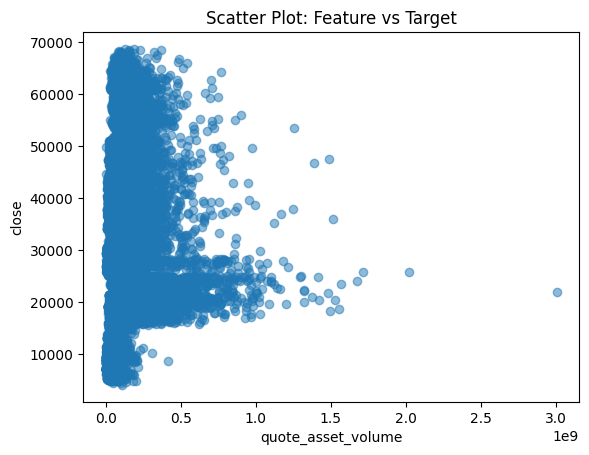

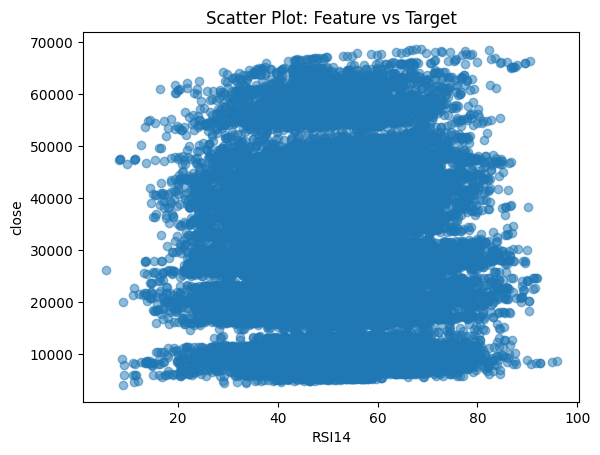

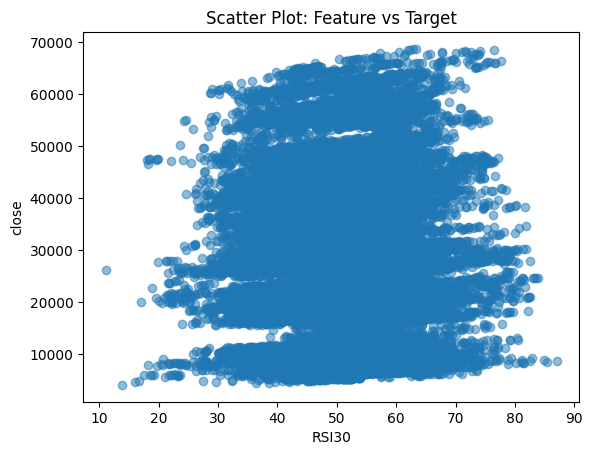

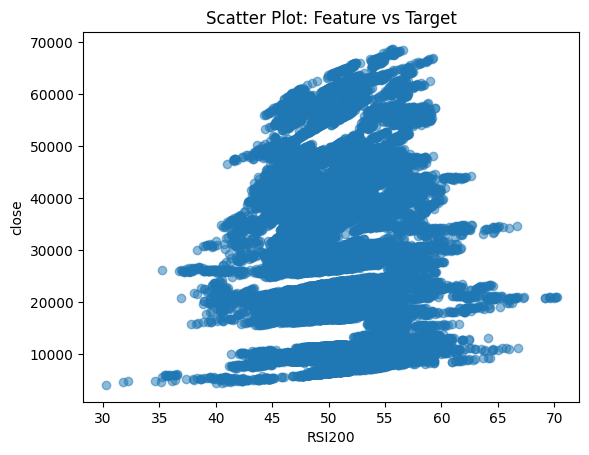

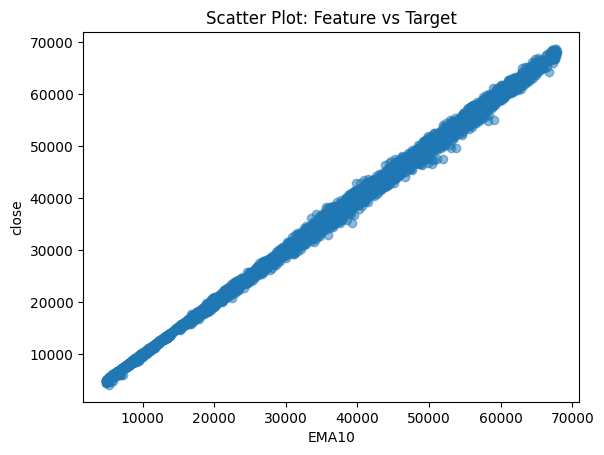

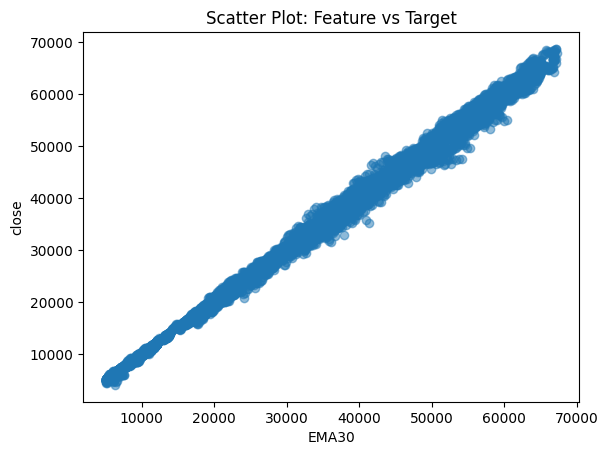

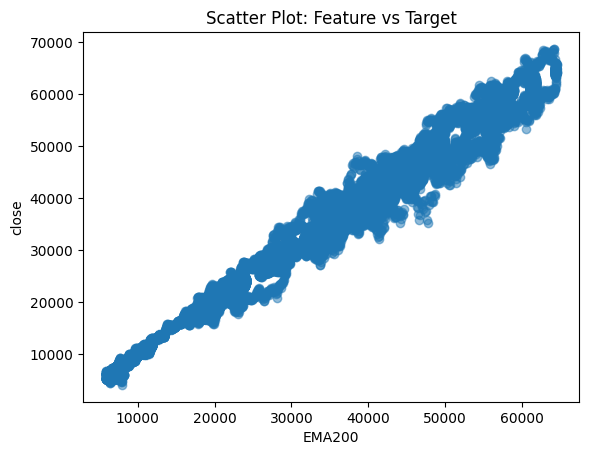

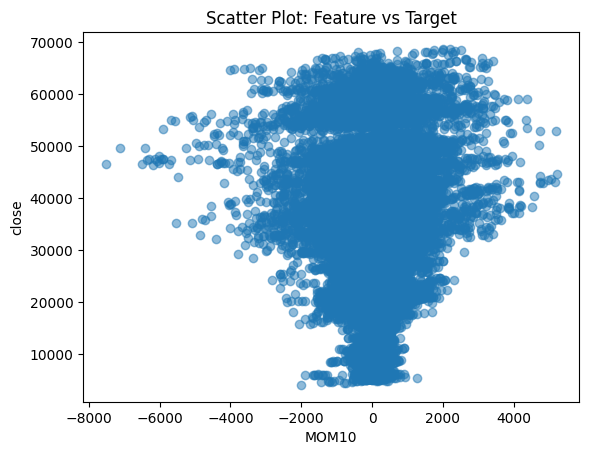

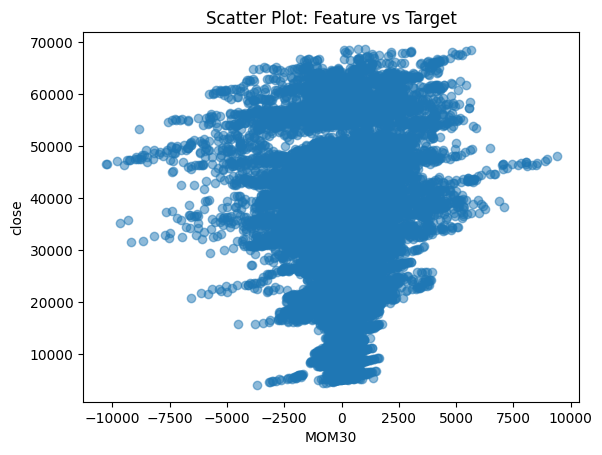

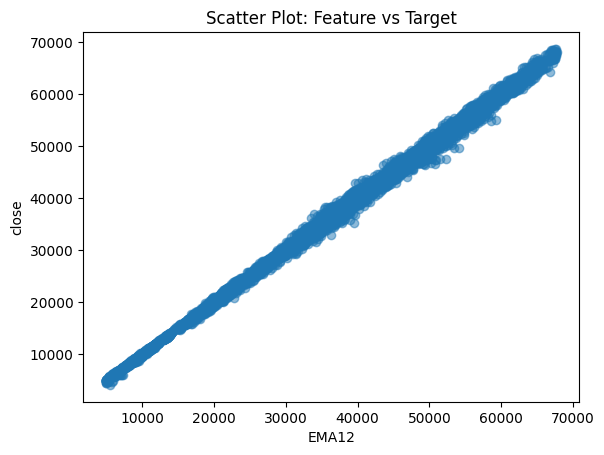

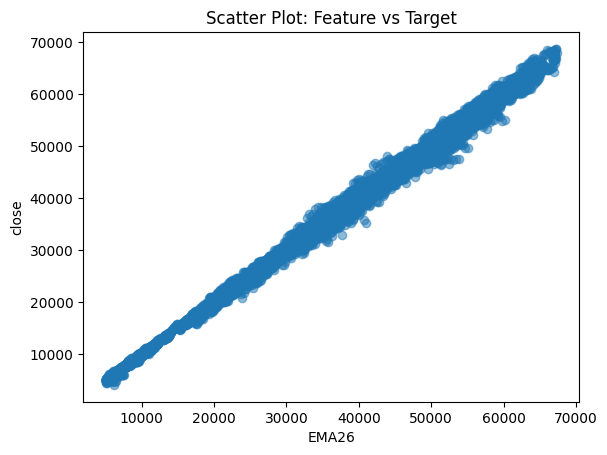

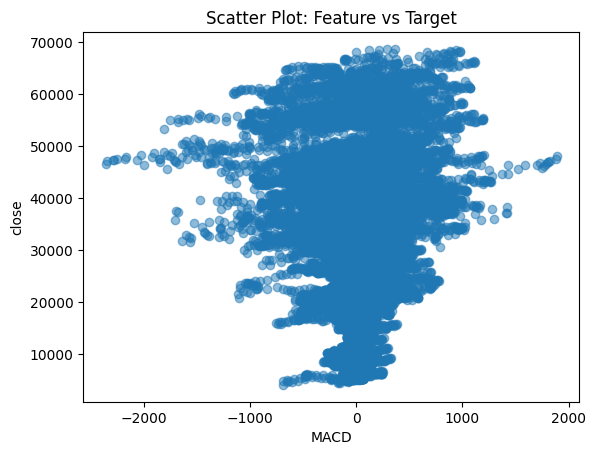

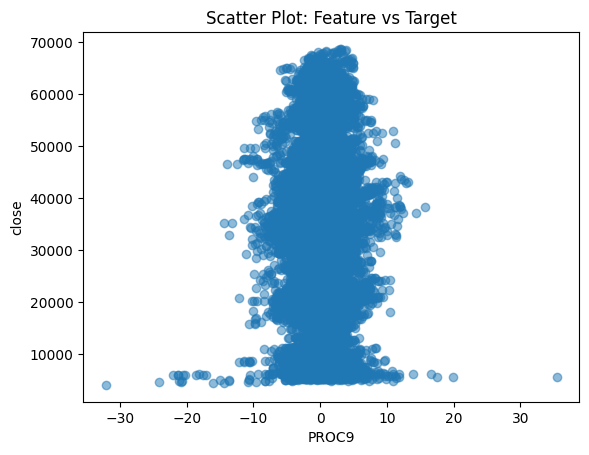

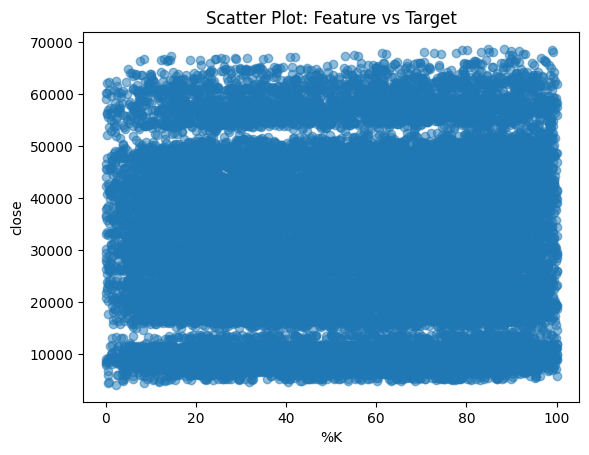

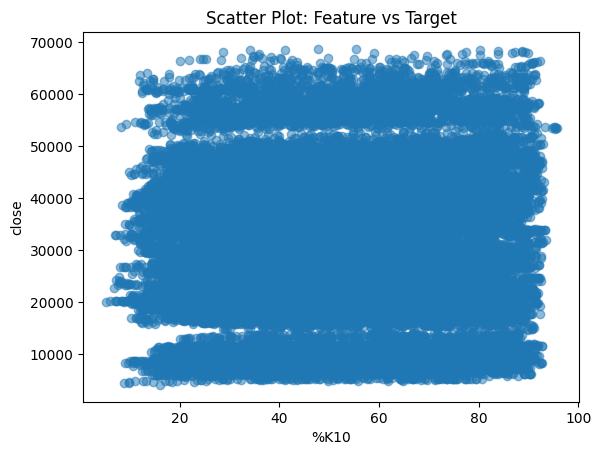

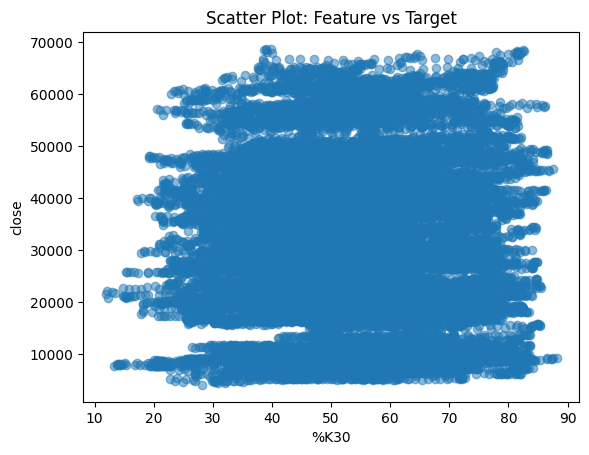

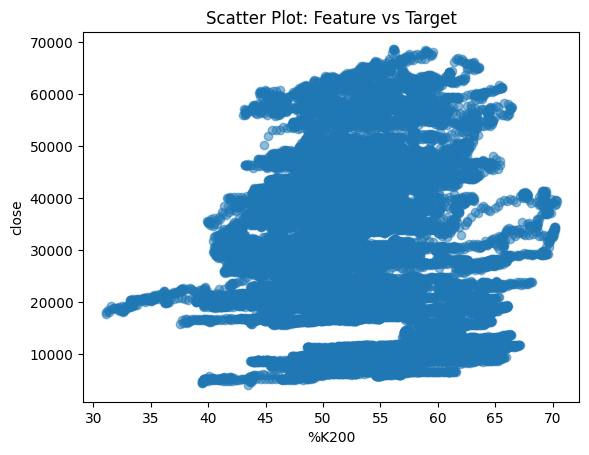

In [4]:
import matplotlib.pyplot as plt
columns= ['open', 'high', 'low', 'close', 'volume',
       'quote_asset_volume', 'RSI14', 'RSI30', 'RSI200', 'EMA10', 'EMA30',
       'EMA200', 'MOM10', 'MOM30', 'EMA12', 'EMA26', 'MACD', 'PROC9',
       '%K', '%K10', '%K30', '%K200']
for col in columns:
    plt.scatter(df1[col], df1['close'], alpha=0.5)
    plt.xlabel(col)
    plt.ylabel('close')
    plt.title('Scatter Plot: Feature vs Target')
    plt.show()


In [6]:
close_mean= df1['close'].mean()
close_std= df1['close'].std()
print (close_mean)
print (close_std)

29237.43313166667
15074.52244455303


In [7]:
from sklearn.preprocessing import StandardScaler
columns= ['open', 'high', 'low', 'close', 'volume',
       'quote_asset_volume', 'RSI14', 'RSI30', 'RSI200', 'EMA10', 'EMA30',
       'EMA200', 'MOM10', 'MOM30', 'EMA12', 'EMA26', 'MACD', 'PROC9',
       '%K', '%K10', '%K30', '%K200']
scaler = StandardScaler()
df1[columns] = scaler.fit_transform(df1[columns])


In [8]:
df1.head()

,timestamp,open,high,low,close,volume,quote_asset_volume,RSI14,RSI30,RSI200,...,EMA12,EMA26,MACD,PROC9,Low14,High14,%K,%K10,%K30,%K200
0,2020-01-01 00:00:00,-1.462147,-1.463125,-1.462407,-1.463444,-0.682684,-0.824649,NaN,NaN,NaN,...,-1.463497,-1.463501,-0.028766,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-01 01:00:00,-1.463392,-1.460899,-1.462390,-1.460840,-0.609458,-0.801849,NaN,NaN,NaN,...,-1.463097,-1.463308,-0.017064,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-01 02:00:00,-1.460802,-1.459918,-1.460008,-1.459077,-0.654410,-0.815658,NaN,NaN,NaN,...,-1.462486,-1.462999,-0.000104,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-01 03:00:00,-1.459001,-1.459909,-1.459435,-1.460260,-0.629051,-0.807770,NaN,NaN,NaN,...,-1.462152,-1.462800,0.007538,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-01 04:00:00,-1.460173,-1.460899,-1.459766,-1.460774,-0.691363,-0.827165,NaN,NaN,NaN,...,-1.461948,-1.462654,0.010804,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df1.dropna(inplace=True)

X = df1[['volume',
       'quote_asset_volume', 'RSI14', 'RSI30', 'RSI200', 'MOM10', 'MOM30', 'MACD',
        'PROC9', 'EMA10', 'EMA30', 'EMA200',
       '%K10', '%K30', '%K200']]
y = df1['close']

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [20]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

# Initialize the XGBoost regressor
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=400, learning_rate=0.1, max_depth=4, subsample=0.8, colsample_bytree=0.8)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print ("Error on normalized data:")
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')

rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

r2_score= r2_score(y_test, y_pred)
print(f"R2 Score: {r2_score}")

mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

print ("\nFinal error:")
print ("MAE ", mae*close_std)
print ("RMSE ", rmse*close_std)

Error on normalized data:
MSE: 0.0004852225955540905
RMSE: 0.022027768737529693
R2 Score: 0.9974135486831418
MAE: 0.013782644678944904

Final error:
MAE  207.76678655805435
RMSE  332.0580942373149
